In [2]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


# Exploring the relationship between low/high tapasin expressers and HLA genotype <br>
Hypothesis: Since the functional relationship between these genes is important and they come from the same region of the genome, we think there may be a germline relationship <br>
Approach: Test all HLA genotypes with expression to see if there is enrichement (fisher's exact test) <br>
Data: MHC-I/MHC-II typing; tapasin expression is from Su Xian

Tapasin expression groups

In [2]:
df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/clinical/TAPBP/TAPBP_expression.csv', header=None, sep='\t')
df.columns = ['Patient', 'TAPBP']

In [3]:
low_TAPBP_expr_patients = [x.strip() for x in open('/cellar/users/ramarty/Data/hla_ii/clinical/TAPBP/Low_TAPBP.txt').readlines()]
high_TAPBP_expr_patients = [x.strip() for x in open('/cellar/users/ramarty/Data/hla_ii/clinical/TAPBP/High_TAPBP.txt').readlines()]

HLA genotypes

In [4]:
classI_types = pd.read_csv('/cellar/users/ramarty/Data/hla/hla_typing/sample_and_types.with_homomzygous.csv', index_col=0)
classI_types.index = list(classI_types['Sample'])
classII_types = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/hla_types/hla_types.tcga.csv', index_col=0)

In [5]:
classI_types.head()

,A1,A2,B1,B2,C1,C2,Sample,homozygous_A,homozygous_B,homozygous_C
TCGA-P5-A780,A*01:01,A*02:01,B*07:02,B*35:03,C*04:01,C*07:02,TCGA-P5-A780,False,False,False
TCGA-55-A494,A*02:01,A*24:02,B*15:01,B*57:01,C*03:03,C*07:01,TCGA-55-A494,False,False,False
TCGA-BR-8382,A*02:01,A*02:01,B*08:01,B*57:01,C*06:02,C*07:01,TCGA-BR-8382,True,False,False
TCGA-Z2-AA3S,A*02:01,A*02:01,B*07:04,B*52:01,C*07:02,C*12:02,TCGA-Z2-AA3S,True,False,False
TCGA-BR-6564,A*02:01,A*11:01,B*35:03,B*40:01,C*03:04,C*12:03,TCGA-BR-6564,False,False,False


Restricting high/low tapasin expression to patients with types

In [6]:
restricted = classI_types[['Sample']]
def get_last_four_digits(x):
    return x[-4:]
restricted['last_four'] = classI_types['Sample'].apply(get_last_four_digits)

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
restricted = restricted[restricted.last_four.isin(low_TAPBP_expr_patients+high_TAPBP_expr_patients)]

In [11]:
def get_expression(x):
    if x in low_TAPBP_expr_patients:
        return 'low'
    elif x in high_TAPBP_expr_patients:
        return 'high'
    else:
        return 'med'
restricted['expression'] = restricted.last_four.apply(get_expression)

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
low_TAPBP_expr_patients = list(restricted[restricted.expression == 'low'].Sample)
high_TAPBP_expr_patients = list(restricted[restricted.expression == 'high'].Sample)

Actual analysis

In [14]:
all_alleles = list(set(list(classI_types.A1)+list(classI_types.A2)+
                      list(classI_types.B1)+list(classI_types.B2)+
                      list(classI_types.C1)+list(classI_types.C2)))
print len(all_alleles)

245


In [15]:
ORs, Ps, alleles_used, patient_frequency = [], [], [], []
for i, allele in enumerate(all_alleles):
    
    if i % 10 == 0:
        print i
    def allele_present(x):
        if allele in list(x):
            return True
        else:
            return False
    classI_types['allele_present'] = classI_types[['A1', 'A2', 'B1', 'B2', 'C1', 'C2']].apply(allele_present, axis=1)
    
    patients_with_allele = list(classI_types[classI_types.allele_present].index)
    
    if len(patients_with_allele) > 25:
        patients_without_allele = list(classI_types[~classI_types.allele_present].index)
    
        OR, P = sp.fisher_exact([[len([x for x in low_TAPBP_expr_patients if x in patients_with_allele]),
                          len([x for x in low_TAPBP_expr_patients if x in patients_without_allele])],
                         [len([x for x in high_TAPBP_expr_patients if x in patients_with_allele]),
                          len([x for x in high_TAPBP_expr_patients if x in patients_without_allele])]])
        ORs.append(OR)
        Ps.append(P)
        alleles_used.append(allele)
        patient_frequency.append(float(len(patients_with_allele))/(len(patients_with_allele)+len(patients_without_allele)))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


In [80]:
results_df = pd.DataFrame({'Allele': alleles_used,
                           'OR': ORs, 
                           'P': Ps,
                           'Allele_frequency': patient_frequency})
print len(results_df)

112


In [81]:
stats = importr('stats')
results_df['P_BH_adjusted'] = stats.p_adjust(FloatVector(list(results_df.P)), method = 'BH')

In [82]:
results_df.sort_values('P_BH_adjusted').to_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/TAPBP/tapasin_hla_genotype.fisher_exact_results.csv')

In [9]:
results_df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/TAPBP/tapasin_hla_genotype.fisher_exact_results.csv',
                        index_col=0)

In [11]:
results_df.sort_values('P_BH_adjusted').head(13)

,Allele,Allele_frequency,OR,P,P_BH_adjusted
22,B*08:01,0.167598,1.461516,8.228516e-07,0.000092
97,C*02:10,0.012705,0.172835,1.132717e-05,0.000634
63,B*53:01,0.022665,0.394872,2.721334e-04,0.007385
41,B*15:03,0.012400,0.270408,2.975389e-04,0.007385
89,A*23:01,0.045940,0.574037,3.297058e-04,0.007385
6,B*57:03,0.006810,0.086957,4.960796e-04,0.009260
27,C*07:01,0.261815,1.256113,6.561299e-04,0.010498
80,B*54:01,0.003659,3.655952,8.868894e-04,0.012416
59,A*36:01,0.006403,0.096488,1.827591e-03,0.022743
2,A*24:07,0.002846,3.743891,3.079381e-03,0.034000


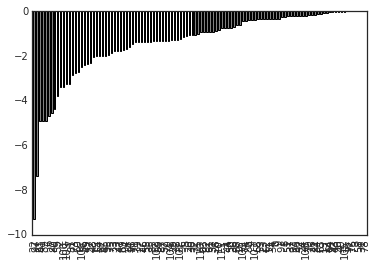

In [95]:
np.log(results_df.sort_values('P_BH_adjusted').P_BH_adjusted).plot(kind='bar', color='grey')

### Do other associations depend on B*08:01? 

In [16]:
allele = 'B*08:01'
def allele_present(x):
    if allele in list(x):
        return True
    else:
        return False
classI_types['allele_present'] = classI_types[['A1', 'A2', 'B1', 'B2', 'C1', 'C2']].apply(allele_present, axis=1)

patients_with_B0801 = list(classI_types[classI_types.allele_present].index)

In [7]:
len(patients_with_allele)

1649

In [14]:
significant_alleles = list(results_df.sort_values('P_BH_adjusted').head(13).Allele)[1:]

In [15]:
significant_alleles

['C*02:10',
 'B*53:01',
 'B*15:03',
 'A*23:01',
 'B*57:03',
 'C*07:01',
 'B*54:01',
 'A*36:01',
 'A*24:07',
 'A*74:01',
 'B*58:02',
 'C*05:01']

In [44]:
ORs, Ps, alleles_used, patient_frequency, segregation, number_positive = [], [], [], [], [], []
association = 'with_B0801'
for allele in significant_alleles:

    def allele_present(x):
        if allele in list(x):
            return True
        else:
            return False
    classI_types['allele_present'] = classI_types[['A1', 'A2', 'B1', 'B2', 'C1', 'C2']].apply(allele_present, axis=1)

    patients_with_allele = [x for x in list(classI_types[classI_types.allele_present].index) if x in patients_with_B0801]

    if len(patients_with_allele) > 2:
        patients_without_allele = [x for x in list(classI_types[~classI_types.allele_present].index) if x in patients_with_B0801]

        OR, P = sp.fisher_exact([[len([x for x in low_TAPBP_expr_patients if x in patients_with_allele]),
                          len([x for x in low_TAPBP_expr_patients if x in patients_without_allele])],
                         [len([x for x in high_TAPBP_expr_patients if x in patients_with_allele]),
                          len([x for x in high_TAPBP_expr_patients if x in patients_without_allele])]])
        ORs.append(OR)
        Ps.append(P)
        alleles_used.append(allele)
        patient_frequency.append(float(len(patients_with_allele))/(len(patients_with_allele)+len(patients_without_allele)))
        segregation.append(association)
        number_positive.append(len(patients_with_allele))
        
association = 'without_B0801'
for allele in significant_alleles:

    def allele_present(x):
        if allele in list(x):
            return True
        else:
            return False
    classI_types['allele_present'] = classI_types[['A1', 'A2', 'B1', 'B2', 'C1', 'C2']].apply(allele_present, axis=1)

    patients_with_allele = [x for x in list(classI_types[classI_types.allele_present].index) if x not in patients_with_B0801]

    if len(patients_with_allele) > 2:
        patients_without_allele = [x for x in list(classI_types[~classI_types.allele_present].index) if x in patients_with_B0801]

        OR, P = sp.fisher_exact([[len([x for x in low_TAPBP_expr_patients if x in patients_with_allele]),
                          len([x for x in low_TAPBP_expr_patients if x in patients_without_allele])],
                         [len([x for x in high_TAPBP_expr_patients if x in patients_with_allele]),
                          len([x for x in high_TAPBP_expr_patients if x in patients_without_allele])]])
        ORs.append(OR)
        Ps.append(P)
        alleles_used.append(allele)
        patient_frequency.append(float(len(patients_with_allele))/(len(patients_with_allele)+len(patients_without_allele)))
        segregation.append(association)
        number_positive.append(len(patients_with_allele))

In [45]:
stats = importr('stats')
results_df = pd.DataFrame({'Allele': alleles_used,
                           'OR': ORs, 
                           'P': Ps,
                           'Allele_frequency': patient_frequency,
                           'B0801_patients': segregation,
                           'Number_of_positive_patients': number_positive})
results_df['P_BH_adjusted'] = stats.p_adjust(FloatVector(list(results_df.P)), method = 'BH')

In [46]:
results_df

,Allele,Allele_frequency,B0801_patients,Number_of_positive_patients,OR,P,P_BH_adjusted
0,C*02:10,0.002426,with_B0801,4,0.000000,5.786032e-01,0.729009
1,B*53:01,0.003639,with_B0801,6,0.817944,1.000000e+00,1.000000
2,B*15:03,0.003639,with_B0801,6,0.000000,5.964619e-01,0.729009
3,A*23:01,0.032141,with_B0801,53,0.699614,4.731736e-01,0.729009
4,B*57:03,0.001819,with_B0801,3,0.000000,1.000000e+00,1.000000
5,C*07:01,0.964221,with_B0801,1590,0.999499,1.000000e+00,1.000000
6,A*36:01,0.003032,with_B0801,5,0.000000,5.786032e-01,0.729009
7,A*74:01,0.002426,with_B0801,4,1.639373,5.508027e-01,0.729009
8,B*58:02,0.002426,with_B0801,4,0.000000,1.000000e+00,1.000000
9,C*05:01,0.091571,with_B0801,151,0.734260,2.817584e-01,0.516557
